In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
# #Pre-process images

# train_images = os.listdir('../input/wnetdataset/data/Data/train')
# val_images = os.listdir('../input/wnetdataset/data/Data/val')

# X_train = []
# X_val = []

# for i in range(len(train_images)):
#     img = cv2.imread('../input/wnetdataset/data/Data/train/'+train_images[i])
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
#     resized = resized/255
#     resized = resized[:, :, np.newaxis]
#     X_train.append(resized)
# X_train = np.asarray(X_train)

# for i in range(len(val_images)):
#     img = cv2.imread('../input/wnetdataset/data/Data/val/'+val_images[i])
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
#     resized = resized/255
#     resized = resized[:, :, np.newaxis]
#     X_val.append(resized)
# X_val = np.asarray(X_val)
    
    
# print(len(X_train))
# print(len(X_val))

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

train_path = '../input/wnet-data-large/data_large/Data_Large/train/'
val_path = '../input/wnet-data-large/data_large/Data_Large/val/'

train_images = os.listdir(train_path)
val_images = os.listdir(val_path)

X_train = []
X_val = []

# Prepare X_train

for i in range(len(train_images)):
    img = cv2.imread(train_path+train_images[i]) #read all images
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Convert images to Grayscale
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) #Resize image to (224, 224)
    X_train.append(resized) # append to list
    
X_train = np.asarray(X_train) #convert to numpy array
X_train = X_train.astype('float32')/255. # Standardizing the data
X_train = np.reshape(X_train, (len(X_train), 224, 224, 1)) #reshape it to (1140, 224, 224, 1) for feeding to model

#Prepare X_val

for i in range(len(val_images)):
    img = cv2.imread(val_path+val_images[i]) #read all images
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # Convert images to Grayscale
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) #Resize image to (224, 224)
    X_val.append(resized) # append to list
    
X_val = np.asarray(X_val) #convert to numpy array
X_val = X_val.astype('float32')/255. # Standardizing the data
X_val = np.reshape(X_val, (len(X_val), 224, 224, 1)) #reshape it to (100, 224, 224, 1) fro feeding to model

print("Number of train images:",len(X_train), "Shape of X_train:", X_train.shape)
print("Number of val images:",len(X_val), "Shape of X_val:", X_val.shape)

Number of train images: 1140 Shape of X_train: (1140, 224, 224, 1)
Number of val images: 100 Shape of X_val: (100, 224, 224, 1)


In [5]:
# from keras.datasets import mnist
# import numpy as np
# (x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print (x_train.shape)
# print (x_test.shape)


In [6]:
height = width = 224
channels = 1
keep_prob = 0.75
num_outputs = 3 #background, cell boundary, cell.
is_train = tf.constant(True, dtype=tf.bool)
num_epochs = 5
num_batches = 120
batch_size = 4
# batch_size = len(X_train)//num_batches
r = 10
sigma_dist = 1
sigma_pixel = tf.square(tf.constant(3.0))
batch_size


4

In [23]:
def conv_layer(bottom, k_size, num_outputs, stride, name, padding='SAME'):

    with tf.variable_scope('conv_layer', reuse = tf.AUTO_REUSE):
        input_channels = int(bottom.get_shape()[-1])
        weights = tf.Variable(tf.truncated_normal(shape=[k_size, k_size, input_channels, num_outputs], dtype=tf.float32,
                                                  stddev=np.sqrt(1.0 / (k_size * k_size * input_channels))),
                              name='weights')
        biases = tf.Variable(tf.constant(0, dtype=tf.float32, shape=[num_outputs]), name='biases')
        conv = tf.nn.conv2d(bottom, weights, strides=[1, stride, stride, 1], padding=padding)
        bias = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))
        relu = tf.nn.relu(bias, name=name)
    return relu

def batch_norm(bottom, phase_train):
    n_out = bottom.get_shape()[-1]

    with tf.variable_scope('batch_normalization', reuse = tf.AUTO_REUSE):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]), name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]), name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(bottom, [0, 1, 2], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        
        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)
            
        mean, var = tf.cond(phase_train, mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(bottom, mean, var, beta, gamma, 1e-3)

    return normed

def conv_layer_with_bn(bottom, ksize, num_outputs, phase_training, name):
    in_channels = int(bottom.get_shape()[-1])
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        weights = tf.Variable(tf.truncated_normal(shape=[ksize, ksize, in_channels, num_outputs],
                                                  dtype=tf.float32,
                                                  stddev=np.sqrt(1.0 / (ksize * ksize * in_channels))),
                              name='filters')
        biases = tf.Variable(tf.constant(0, dtype=tf.float32, shape=[num_outputs]), name='biases')
        conv = tf.nn.conv2d(bottom, weights, [1, 1, 1, 1], padding='SAME')
        bias = tf.nn.bias_add(conv, biases)
        conv_norm = batch_norm(bias, phase_training)
        conv_relu = tf.nn.relu(conv_norm)

    return conv_relu

def sep_conv_layer(bottom, ksize, num_outputs, phase_training, name, multiplier=1):
    in_channels = int(bottom.get_shape()[-1])
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        depthwise_filter = tf.Variable(tf.truncated_normal(shape=[ksize, ksize, in_channels, multiplier],
                                                           dtype=tf.float32,
                                                           stddev=np.sqrt(1.0 / (ksize * ksize * in_channels))),
                                       name='depthwise_filter')
        pointwise_filter = tf.Variable(tf.truncated_normal(shape=[1, 1, in_channels * multiplier, num_outputs],
                                                           dtype=tf.float32,
                                                           stddev=np.sqrt(1.0 / (ksize * ksize * in_channels))),
                                       name='pointwise_filter')
        biases = tf.Variable(tf.constant(0, dtype=tf.float32, shape=[num_outputs]), name='biases')
        sep_conv = tf.nn.separable_conv2d(bottom,
                                          depthwise_filter=depthwise_filter,
                                          pointwise_filter=pointwise_filter,
                                          strides=[1, 1, 1, 1], padding='SAME', name='sep_conv' + name)
        sep_bias = tf.nn.bias_add(sep_conv, biases)
        sep_norm = batch_norm(sep_bias, phase_training)
        sep_relu = tf.nn.relu(sep_norm)

    return sep_relu

def max_pooling(bottom, k_size, stride, name, padding='valid'):
    return tf.layers.max_pooling2d(bottom, pool_size=[k_size, k_size], strides=stride, padding=padding, name=name)



In [24]:
def upconv_concat(bottom_a, bottom_b, n_filter, k_size, stride, name, padding='VALID'):

    with tf.name_scope(name):
        up_conv = tf.layers.conv2d_transpose(bottom_a, filters=n_filter, kernel_size=[k_size, k_size],
                                             strides=stride, padding=padding)
        return tf.concat([up_conv, bottom_b], axis=-1, name="concat_{}".format(name))

In [25]:
with tf.name_scope('Encoder'):
    def encoder(input_img):
#         tf.layers.conv2d()
        conv_1_1 = conv_layer_with_bn(input_img, 3, 64, is_train, "conv_1_1")
        conv_1_1_drop = tf.nn.dropout(conv_1_1, keep_prob)
        conv_1_2 = conv_layer_with_bn(conv_1_1_drop, 3, 64, is_train, "conv_1_2")
        conv_1_2_drop = tf.nn.dropout(conv_1_2, keep_prob)

        pool_1 = max_pooling(conv_1_2_drop, k_size=2, stride=2, padding="valid", name="pool_1")

        conv_2_1 = sep_conv_layer(pool_1, 3, 128, is_train, "conv_2_1")
        conv_2_1_drop = tf.nn.dropout(conv_2_1, keep_prob)
        conv_2_2 = sep_conv_layer(conv_2_1_drop, 3, 128, is_train, "conv_2_2")
        conv_2_2_drop = tf.nn.dropout(conv_2_2, keep_prob)

        pool_2 = max_pooling(conv_2_2_drop, k_size=2, stride=2, padding="valid", name="pool_2")

        conv_3_1 = sep_conv_layer(pool_2, 3, 256, is_train, "conv_3_1")
        conv_3_1_drop = tf.nn.dropout(conv_3_1, keep_prob)
        conv_3_2 = sep_conv_layer(conv_3_1_drop, 3, 256, is_train, "conv_3_2")
        conv_3_2_drop = tf.nn.dropout(conv_3_2, keep_prob)

        pool_3 = max_pooling(conv_3_2_drop, k_size=2, stride=2, padding="valid", name="pool_3")

        conv_4_1 = sep_conv_layer(pool_3, 3, 512, is_train, "conv_4_1")
        conv_4_1_drop = tf.nn.dropout(conv_4_1, keep_prob)
        conv_4_2 = sep_conv_layer(conv_4_1_drop, 3, 512, is_train, "conv_4_2")
        conv_4_2_drop = tf.nn.dropout(conv_4_2, keep_prob)

        pool_4 = max_pooling(conv_4_2_drop, k_size=2, stride=2, padding="valid", name="enc_pool_4")

        conv_5_1 = sep_conv_layer(pool_4, 3, 1024, is_train, "conv_5_1")
        conv_5_1_drop = tf.nn.dropout(conv_5_1, keep_prob)
        conv_5_2 = sep_conv_layer(conv_5_1_drop, 3, 1024, is_train, "conv_5_2")
        conv_5_2_drop = tf.nn.dropout(conv_5_2, keep_prob)

        # rectangle 6
        upconv_1 = upconv_concat(conv_5_2_drop, conv_4_2_drop, n_filter=512, k_size=2, stride=2, name="enc_upconv_1")

        conv_6_1 = sep_conv_layer(upconv_1, 3, 512, is_train, "conv_6_1")
        conv_6_1_drop = tf.nn.dropout(conv_6_1, keep_prob)
        conv_6_2 = sep_conv_layer(conv_6_1_drop, 3, 512, is_train, "conv_6_2")
        conv_6_2_drop = tf.nn.dropout(conv_6_2, keep_prob)

        upconv_2 = upconv_concat(conv_6_2_drop, conv_3_2_drop, n_filter=256, k_size=2, stride=2, name="enc_upconv_2")

        conv_7_1 = sep_conv_layer(upconv_2, 3, 256, is_train, "conv_7_1")
        conv_7_1_drop = tf.nn.dropout(conv_7_1, keep_prob)
        conv_7_2 = sep_conv_layer(conv_7_1_drop, 3, 256, is_train, "conv_7_2")
        conv_7_2_drop = tf.nn.dropout(conv_7_2, keep_prob)

        upconv_3 = upconv_concat(conv_7_2_drop, conv_2_2_drop, n_filter=128, k_size=2, stride=2, name="enc_upconv_3")

        conv_8_1 = sep_conv_layer(upconv_3, 3, 128, is_train, "conv_8_1")
        conv_8_1_drop = tf.nn.dropout(conv_8_1, keep_prob)
        conv_8_2 = sep_conv_layer(conv_8_1_drop, 3, 128, is_train, "conv_8_2")
        conv_8_2_drop = tf.nn.dropout(conv_8_2, keep_prob)

        upconv_4 = upconv_concat(conv_8_2_drop, conv_1_2_drop, n_filter=64, k_size=2, stride=2, name="enc_upconv_4")

        conv_9_1 = conv_layer_with_bn(upconv_4, 3, 64, is_train, "conv_9_1")
        conv_9_1_drop = tf.nn.dropout(conv_9_1, keep_prob)
        conv_9_2 = conv_layer_with_bn(conv_9_1_drop, 3, 64, is_train, "conv_9_2")
        conv_9_2_drop = tf.nn.dropout(conv_9_2, keep_prob)
        print(conv_9_2_drop.shape, "conv_9_2_drop") 
        conv = conv_layer(conv_9_2_drop, k_size=1, num_outputs=num_outputs, stride=1, name="conv_for_softmax")
        print(conv.shape, "conv")
        return tf.nn.softmax(conv, axis = 3, name = 'probs')

In [26]:
with tf.name_scope('Encoder'):
    def encoder(input_img):
        conv_1_1 = tf.layers.conv2d(input_img, 64, 3, padding = 'same', activation = 'relu', name = "conv_1_1")
        conv_1_1_bn = tf.layers.batch_normalization(conv_1_1)
        conv_1_1_drop = tf.layers.dropout(conv_1_1_bn, keep_prob)
        
        conv_1_2 = tf.layers.conv2d(conv_1_1_drop, 64, 3, padding = 'same', activation = 'relu', name = "conv_1_2")
        conv_1_2_bn = tf.layers.batch_normalization(conv_1_2)
        conv_1_2_drop = tf.layers.dropout(conv_1_2_bn, keep_prob)

        
        pool_1 = tf.layers.max_pooling2d(conv_1_2_drop, pool_size=2, strides=2, padding="valid", name="pool_1")

        
        conv_2_1 = tf.layers.separable_conv2d(pool_1, 128, 3, padding = 'same', activation = 'relu', name = "conv_2_1")        
        conv_2_1_bn = tf.layers.batch_normalization(conv_2_1)
        conv_2_1_drop = tf.layers.dropout(conv_2_1_bn, keep_prob)
        
        conv_2_2 = tf.layers.separable_conv2d(conv_2_1_drop, 128, 3, padding = 'same', activation = 'relu', name = "conv_2_2")
        conv_2_2_bn = tf.layers.batch_normalization(conv_2_2)
        conv_2_2_drop = tf.layers.dropout(conv_2_2_bn, keep_prob)
        

        pool_2 = tf.layers.max_pooling2d(conv_2_2_drop, pool_size=2, strides=2, padding="valid", name="pool_2")
        

        conv_3_1 = tf.layers.separable_conv2d(pool_2, 256, 3, padding = 'same', activation = 'relu', name = "conv_3_1")        
        conv_3_1_bn = tf.layers.batch_normalization(conv_3_1)
        conv_3_1_drop = tf.layers.dropout(conv_3_1_bn, keep_prob)
        
        conv_3_2 = tf.layers.separable_conv2d(conv_3_1_drop, 256, 3, padding = 'same', activation = 'relu', name = "conv_3_2")
        conv_3_2_bn = tf.layers.batch_normalization(conv_3_2)
        conv_3_2_drop = tf.layers.dropout(conv_3_2_bn, keep_prob)

        
        pool_3 = tf.layers.max_pooling2d(conv_3_2_drop, pool_size=2, strides=2, padding="valid", name="pool_3")

        
        conv_4_1 = tf.layers.separable_conv2d(pool_3, 512, 3, padding = 'same', activation = 'relu', name = "conv_4_1")        
        conv_4_1_bn = tf.layers.batch_normalization(conv_4_1)
        conv_4_1_drop = tf.layers.dropout(conv_4_1_bn, keep_prob)
        
        conv_4_2 = tf.layers.separable_conv2d(conv_4_1_drop, 512, 3, padding = 'same', activation = 'relu', name = "conv_4_2")
        conv_4_2_bn = tf.layers.batch_normalization(conv_4_2)
        conv_4_2_drop = tf.layers.dropout(conv_4_2_bn, keep_prob)
        

        pool_4 = tf.layers.max_pooling2d(conv_4_2_drop, pool_size=2, strides=2, padding="valid", name="pool_4")

        
        conv_5_1 = tf.layers.separable_conv2d(pool_4, 1024, 3, padding = 'same', activation = 'relu', name = "conv_5_1")        
        conv_5_1_bn = tf.layers.batch_normalization(conv_5_1)
        conv_5_1_drop = tf.layers.dropout(conv_5_1_bn, keep_prob)
        
        conv_5_2 = tf.layers.separable_conv2d(conv_5_1_drop, 1024, 3, padding = 'same', activation = 'relu', name = "conv_5_2")
        conv_5_2_bn = tf.layers.batch_normalization(conv_5_2)
        conv_5_2_drop = tf.layers.dropout(conv_5_2_bn, keep_prob)


        upconv_1 = upconv_concat(conv_5_2_drop, conv_4_2_drop, n_filter=512, k_size=2, stride=2, name="enc_upconv_1")

        
        conv_6_1 = tf.layers.separable_conv2d(upconv_1, 512, 3, padding = 'same', activation = 'relu', name = "conv_6_1")        
        conv_6_1_bn = tf.layers.batch_normalization(conv_6_1)
        conv_6_1_drop = tf.layers.dropout(conv_6_1_bn, keep_prob)
        
        conv_6_2 = tf.layers.separable_conv2d(conv_6_1_drop, 512, 3, padding = 'same', activation = 'relu', name = "conv_6_2")
        conv_6_2_bn = tf.layers.batch_normalization(conv_6_2)
        conv_6_2_drop = tf.layers.dropout(conv_6_2_bn, keep_prob)

        
        upconv_2 = upconv_concat(conv_6_2_drop, conv_3_2_drop, n_filter=256, k_size=2, stride=2, name="enc_upconv_2")

        
        conv_7_1 = tf.layers.separable_conv2d(upconv_2, 256, 3, padding = 'same', activation = 'relu', name = "conv_7_1")
        conv_7_1_bn = tf.layers.batch_normalization(conv_7_1)
        conv_7_1_drop = tf.layers.dropout(conv_7_1_bn, keep_prob)
        
        conv_7_2 = tf.layers.separable_conv2d(conv_7_1_drop, 256, 3, padding = 'same', activation = 'relu', name = "conv_7_2")
        conv_7_2_bn = tf.layers.batch_normalization(conv_7_2)
        conv_7_2_drop = tf.layers.dropout(conv_7_2_bn, keep_prob)

        
        upconv_3 = upconv_concat(conv_7_2_drop, conv_2_2_drop, n_filter=128, k_size=2, stride=2, name="enc_upconv_3")

        
        conv_8_1 = tf.layers.separable_conv2d(upconv_3, 128, 3, padding = 'same', activation = 'relu', name = "conv_8_1")
        conv_8_1_bn = tf.layers.batch_normalization(conv_8_1)
        conv_8_1_drop = tf.layers.dropout(conv_8_1_bn, keep_prob)
        
        conv_8_2 = tf.layers.separable_conv2d(conv_8_1_drop, 128, 3, padding = 'same', activation = 'relu', name = "conv_8_2")
        conv_8_2_bn = tf.layers.batch_normalization(conv_8_2)
        conv_8_2_drop = tf.layers.dropout(conv_8_2_bn, keep_prob)

        
        upconv_4 = upconv_concat(conv_8_2_drop, conv_1_2_drop, n_filter=64, k_size=2, stride=2, name="enc_upconv_4")

        
        conv_9_1 = tf.layers.separable_conv2d(upconv_4, 64, 3, padding = 'same', activation = 'relu', name = "conv_9_1")
        conv_9_1_bn = tf.layers.batch_normalization(conv_9_1)
        conv_9_1_drop = tf.layers.dropout(conv_9_1_bn, keep_prob)
        
        conv_9_2 = tf.layers.separable_conv2d(conv_9_1_drop, 64, 3, padding = 'same', activation = 'relu', name = "conv_9_2")
        conv_9_2_bn = tf.layers.batch_normalization(conv_9_2)
        conv_9_2_drop = tf.layers.dropout(conv_9_2_bn, keep_prob)
        
        
        conv = tf.layers.conv2d(conv_9_2_drop, 3, kernel_size=3, strides=1, activation = 'relu', name="conv_for_softmax")
        print(conv.shape, "conv")
        return tf.nn.softmax(conv, axis = 3, name = 'probs')

In [27]:
init = tf.global_variables_initializer()

## LOSS

In [28]:
# s = 2 * r + 1
# spatial_kernel = np.zeros((s, s), dtype=np.float32)
# for y in range(s):
#     for x in range(s):
#         # calculate squared euclidean distance
#         dist = (x - r) * (x - r) + (y - r) * (y - r)
#         if dist < (r * r):
#             spatial_kernel[y][x] = np.exp((-dist) / sigma_dist)

# spatial_kernel = tf.constant(spatial_kernel.reshape(-1), dtype=tf.float32)

# #create one dimensional kernel

# s = 2 * r + 1
# one_dim_kernel = np.zeros((s, s, (s * s)))
# for i in range(s * s):
#     one_dim_kernel[int(i / s)][i % s][i] = 1.0
# one_dim_kernel = one_dim_kernel.reshape(s, s, 1, (s * s))
# one_dim_kernel = tf.constant(one_dim_kernel, dtype=tf.float32)

In [29]:
# def calc_loss(input_img):
#     num_sum = tf.constant(0.0, dtype=tf.float32)
#     for depth in range(num_outputs):
#         softmax_layer = encoder(input_img)[:, :, :, depth:depth + 1] #take each channel of the output image from encoder_model
#         extracted_pixels = tf.nn.conv2d(softmax_layer, one_dim_kernel, strides=[1, 1, 1, 1], padding='SAME')
    
#         intensity_sq_dif = tf.squared_difference(extracted_pixels, softmax_layer)
#         intensity_values = tf.exp(tf.divide(tf.negative(intensity_sq_dif), sigma_pixel))
    
#         weights = tf.multiply(intensity_values, spatial_kernel)
#         # Reshape Input Softmax Layer for correct dimensions
#         u_pixels = tf.reshape(softmax_layer, [batch_size, 224, 224])
    
#         # Calculate entire numerator
#         numerator_inner_sum = tf.reduce_sum(tf.multiply(weights, extracted_pixels), axis=3)
#         numerator_outer_sum = tf.multiply(u_pixels, numerator_inner_sum)
#         numerator = tf.reduce_sum(numerator_outer_sum)
    
#         # Calculate denominator
#         denominator_inner_sum = tf.reduce_sum(weights, axis=3)
#         denominator_outer_sum = tf.multiply(u_pixels, denominator_inner_sum)
#         denominator = tf.reduce_sum(denominator_outer_sum)
    
#         processed_value = numerator / denominator
#         num_sum += processed_value
    
#     return num_outputs - num_sum

In [30]:
from scipy.stats import norm

radius = 5
sigma_std = 4.0
sigma_intensity = 10

In [31]:
def gaussian_kernel(radius, sigma):
    x_2 = np.linspace(-radius, radius, 2*radius+1) ** 2
    dist = np.sqrt(x_2.reshape(-1, 1) + x_2.reshape(1, -1)) / sigma
    kernel = norm.pdf(dist) / norm.pdf(0)
    kernel = tf.convert_to_tensor(kernel)
    kernel = tf.reshape(kernel, (kernel.shape[0], kernel.shape[1], 1, 1))
    return kernel
kernel = gaussian_kernel(radius=radius, sigma=sigma_std)
kernel = tf.cast(kernel, tf.float32)
kernel.shape

TensorShape([Dimension(11), Dimension(11), Dimension(1), Dimension(1)])

In [32]:
def calc_loss(input_img):
    loss = 0
    for k in range(num_outputs):
        
        class_probs = output[:,:,:, k:k+1]
        
        print(class_probs.shape)

        class_mean = tf.reduce_mean(input_img * class_probs, axis = [1,2], keepdims=True) / \
        tf.add(tf.reduce_mean(class_probs, axis = [1,2], keepdims=True), 1e-5)

        diff = tf.reduce_sum(tf.pow((input_img - class_mean), 2), 0, keepdims=True)

        # Weight the loss by the difference from the class average.
        weights = tf.exp(tf.multiply(tf.pow(diff, 2) , -1/ sigma_intensity ** 2))

        # Compute N-cut loss, using the computed weights matrix, and a Gaussian spatial filter
        numerator = tf.reduce_sum(class_probs * tf.nn.conv2d(class_probs * weights, kernel, strides = [1, 1, 1, 1], padding='SAME'))
        denominator = tf.reduce_sum(class_probs * tf.nn.conv2d(weights, kernel, strides = [1, 1, 1, 1], padding="SAME"))
        loss += numerator / tf.add(denominator, 1e-6)

    return num_outputs - loss

In [33]:
input_img = tf.placeholder(dtype=tf.float32, shape=[None, height, width, channels], name='input')
output = encoder(input_img)
loss = calc_loss(input_img)
soft_cut_norm_loss = tf.reduce_mean(loss)

(?, 224, 224, 64) conv_9_2_drop
(?, 224, 224, 3) conv
(?, 224, 224, 1)
(?, 224, 224, 1)
(?, 224, 224, 1)


In [34]:
with tf.name_scope("optimizer"):
    norm_cut_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(soft_cut_norm_loss) #optimizer

In [35]:
init = tf.global_variables_initializer()

In [36]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        print("epoch:", epoch)
        count = 0
        batch_start_index = 0
        while (count != num_batches):
            X_train_batch = X_train[batch_start_index : batch_start_index+batch_size]
            _, train_loss = sess.run([norm_cut_opt,soft_cut_norm_loss], feed_dict={input_img: X_train_batch})
            batch_start_index+=batch_size
            count+=1
        print("Train loss after ", str(epoch), "is", str(train_loss))

epoch: 0
Train loss after  0 is 0.13430429
epoch: 1
Train loss after  1 is 0.096996784
epoch: 2
Train loss after  2 is 0.09846926
epoch: 3
Train loss after  3 is 0.062328577
epoch: 4
Train loss after  4 is 0.06852293


In [37]:
img = cv2.imread('../input/test-dataset/a184.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
resized = resized/255
resized1 = resized[:, :, np.newaxis]
print(resized1.shape)
resized1 = resized1[np.newaxis, :, :] 
print(resized1.shape)

(224, 224, 1)
(1, 224, 224, 1)


In [38]:
output = encoder(input_img)

(?, 224, 224, 64) conv_9_2_drop
(?, 224, 224, 3) conv


In [39]:
init = tf.global_variables_initializer()

In [40]:
with tf.Session() as sess:
    sess.run(init)
    img4 = sess.run(output, feed_dict = {input_img: resized1})

In [41]:
img4 = img4 * 4
# img4

In [42]:
img4.shape

(1, 224, 224, 3)

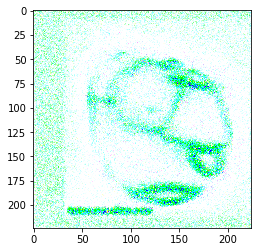

In [43]:
plt.imshow(img4.reshape(224,224,3))

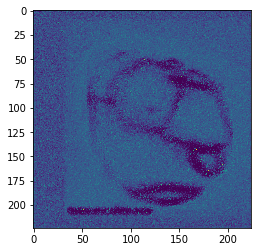

In [44]:
img_resized = img4.reshape(224,224,3).copy()
img_resized = img_resized[:, :, 0]
img_resized = img_resized
plt.imshow(img_resized)

In [ ]:
img4[0][223][0][0] + img4[0][223][0][1] + img4[0][223][0][2] #sum of probabilities of classes should be equal to 1 because we used softmax.

In [ ]:
# img_resized = img4.reshape(224,224,3).copy()
# img_resized[:, :, 0]= 0
# img_resized[:, :, 2]= 0
# img_resized = img_resized * 10
# plt.imshow(img_resized)